## Multi-Class Text Classification with Doc2Vec & Logistic Regression

The goal is to classify consumer finance complaints into 12 pre-defined classes using Doc2Vec and Logistic Regression.

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

### Consumer Complaint Database
> https://catalog.data.gov/dataset/consumer-complaint-database

*Metadata Updated: November 10, 2020*

The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response.

Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first.

Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./complaints-sample.csv')
# df = pd.read_csv('./complaints.csv')
df = df[['Consumer complaint narrative', 'Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns={'Consumer complaint narrative': 'narrative'}, inplace=True)
df.head(10)

,narrative,Product
0,transworld systems inc. \r\nis trying to colle...,Debt collection
2,"Over the past 2 weeks, I have been receiving e...",Debt collection
4,My personal information was used without my kn...,"Credit reporting, credit repair services, or o..."
5,XX/XX/2021 I lost my phone and I didn't notice...,"Money transfer, virtual currency, or money ser..."
10,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit reporting, credit repair services, or o..."
11,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
15,Today XX/XX/XXXX went online to dispute the in...,"Credit reporting, credit repair services, or o..."
17,XXXX is reporting incorrectly to Equifax and X...,"Credit reporting, credit repair services, or o..."
18,Please reverse the late payments reported on t...,"Credit reporting, credit repair services, or o..."
19,Pioneer has committed several federal violatio...,Debt collection


In [2]:
df.shape

(534, 2)

In [3]:
df.index = range(534)
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

127239

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


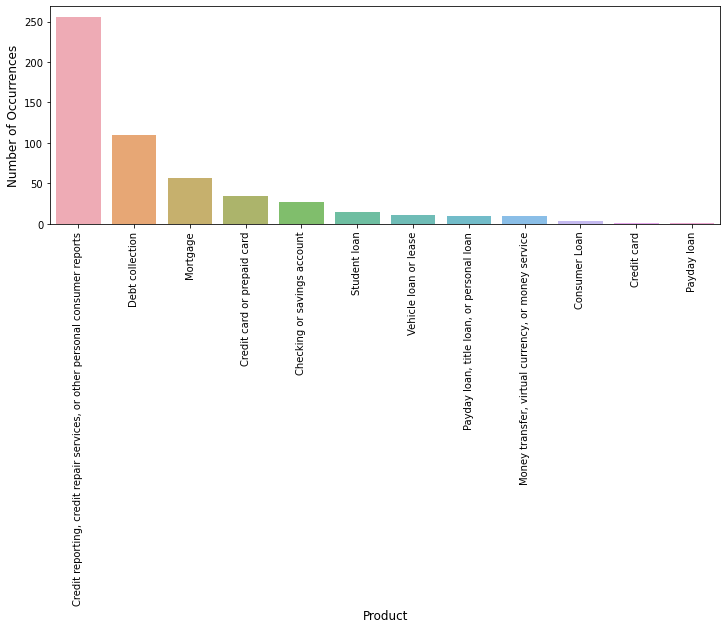

In [4]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12, 4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [5]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


print_complaint(12)

i am a victim of identity theft as previously stated
Product: Credit reporting, credit repair services, or other personal consumer reports


In [6]:
print_complaint(20)

I am a victim of identity theft. The information listed below, which appears on my credit report, does not relate to any transaction ( s )  that I have made. It is the result of identity theft.
Product: Credit reporting, credit repair services, or other personal consumer reports


### Text Preprocessing
- Remove stop-words and tokenize text using NLTK tokenizer

In [7]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [8]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


train_tagged = train.apply(lambda r: TaggedDocument(
    words=tokenize_text(r['narrative']), tags=[r.Product]),
                           axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(
    words=tokenize_text(r['narrative']), tags=[r.Product]),
                         axis=1)

In [9]:
train_tagged.values[30]

TaggedDocument(words=['on', '//', 'sent', 'letter', 'to', 'the', 'hospital', 'to', 'settle', 'any', 'open', 'balance', 'had', 'with', 'them', 'in', 'my', 'letter', 'it', 'sated', 'that', 'wanted', 'to', 'settle', 'the', 'account', 'balance', 'for', '150.00', 'so', 'they', 'had', 'the', 'choice', 'to', 'either', 'decline', 'my', 'proposal', 'and', 'return', 'my', 'check', 'or', 'accept', 'my', 'proposal', 'and', 'cash', 'the', 'check', 'which', 'clearly', 'stated', 'in', 'my', 'letter', 'the', 'hospital', 'did', 'in', 'fact', 'cash', 'my', 'check', 'and', 'have', 'documents', 'to', 'prove', 'it', 'they', 'did', 'in', 'fact', 'cash', 'the', 'check', 'knowing', 'that', 'the', 'check', 'was', 'only', 'to', 'settle', 'the', 'remaining', 'balance', 'on', 'my', 'account', 'and', 'not', 'to', 'send', 'my', 'account', 'to', 'collections', 'or', 'cancel', 'any', 'collections', 'attempts', 'below', 'is', 'what', 'was', 'in', 'the', 'letter', 'sent', 'notice', 'of', 'dispute', 'and', 'settlement',

### Set-up Doc2Vec Training & Evaluation Models

First, we instantiate a doc2vec model — Distributed Bag of Words (DBOW).
In the word2vec architecture, the two algorithm names are “continuous bag of words” (CBOW) and “skip-gram” (SG);
in the doc2vec architecture, the corresponding algorithms are “distributed memory” (DM) and “distributed bag of words” (DBOW).


### Distributed Bag of Words (DBOW)
DBOW is the doc2vec model analogous to Skip-gram model in word2vec.
The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

#### We will vary the following parameters:
- If `dm=0`, distributed bag of words (PV-DBOW) is used; if `dm=1`,‘distributed memory’ (PV-DM) is used.
- `vector_size=300` dimensional feature vectors.
- `min_count=2`, ignores all words with total frequency lower than this.
- `negative=5` , specifies how many “noise words” should be drawn.
- `hs=0` , and negative is non-zero, negative sampling will be used.
- `sample=0` , the threshold for configuring which higher-frequency words are randomly down sampled.
- `workers=cores` , use these many worker threads to train the model (=faster training with multicore machines).

In [10]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [11]:
model_dbow = Doc2Vec(dm=0,
                     vector_size=300,
                     negative=5,
                     hs=0,
                     min_count=2,
                     sample=0,
                     workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 373561.46it/s]


In [12]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                     total_examples=len(train_tagged.values),
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<?, ?it/s]


Wall time: 1.14 s


### Building the Final Vector Feature for the Classifier

In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0],
                                 model.infer_vector(doc.words, steps=20))
                                for doc in sents])
    return targets, regressors


def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0],
                                 model.infer_vector(doc.words, steps=20))
                                for doc in sents])
    return targets, regressors

### Train the Logistic Regression Classifier

In [14]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.40372670807453415
Testing F1 score: 0.2452464011214969


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Distributed Memory (DM)

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph.
While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.
We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [15]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<?, ?it/s]


In [16]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<?, ?it/s]


Wall time: 2 s


### Train the Logistic Regression Classifier

In [17]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5590062111801242
Testing F1 score: 0.5470116681719421


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Pairing

According to Gensim doc2vec tutorial on the IMDB sentiment data set, combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance.
We will follow, pairing the models together for evaluation.

In [18]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

#### Concatenate two models

In [19]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

#### Building feature vectors

In [20]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

#### Train the Logistic Regression

In [21]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6521739130434783
Testing F1 score: 0.6236804129229316


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
